In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import math
from sklearn.metrics import r2_score
from re import S
from pandas.core.frame import DataFrame
from scipy.stats import shapiro, cauchy, t
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table


In [2]:
###read CSV file
csvdata = pd.read_csv("../Z_Data/CSVread3.csv", sep = ";", decimal=",")


In [3]:
###Set log(DilutionF) as index
logspre = csvdata["log(dil)"].values.tolist()
logspre.remove("min")
logspre.remove("max")
logs = []
for i in logspre:
    k = i.replace(",",".")
    k = float(k)
    logs.append(k)

alldata = csvdata.set_index("log(dil)")
alldata.index.names = [None]

In [4]:
###Make Subsets of data
#generate list of names:
rep = int(len(alldata.columns)/3)
dataNames = []
for i in range(rep):
    naam = "sample_" + str(i+1)
    dataNames.append(naam)

#Add Dataframe to name in dictionary
tel = 0
frames = []
for k in range(rep):
    frame = alldata.iloc[:,[tel, tel+1, tel+2]]
    tel = tel+3
    frames.append(frame)

joined = dict(zip(dataNames, frames))


In [5]:
#IC50 curve, initial
def IC50(logs, dict):
    identity = []
    IC50 = []
    oldic50 = []
    hill = []
    oldhill = []
    for names, frame in dict.items():
        identity.append(names)

        mins = frame.loc["min"][0]
        maxs = frame.loc["max"][0]
        dataOnly = frame.drop(["min","max"])

        ###Convert 8x4 dataframe to 24x2
        xvalues = []
        for i in range(len(logs)):
            extra = [logs[i]] * 3
            xvalues.extend(extra)
        lijstdat = dataOnly.stack().tolist()
        lijstdata = [100*(1-(m - mins) / ( maxs - mins )) for m in lijstdat]
        
        ###Limit values to 0-100 range
        #for i in range(len(lijstdata)):
        #    if lijstdata[i]<0:
        #        lijstdata[i] = 0
        #    elif lijstdata[i]>100:
        #        lijstdata[i] = 100

        def logistic_curve(logx, prm):
            return 100 / (1 + 10**((prm[0]-np.asarray(logx))*prm[1]))
            # return ((-100) / (1 + ((np.asarray(logx)/logIC50)**Hill))) + 100

        def residuals(param, xs, ys):
            return (100 / (1 + 10**((param[0]-np.asarray(xs))*param[1])))-ys
                
        param0 = [3, -1]
        line = np.arange(0, 8, 0.1)

        ##Apply soft L1-loss: combinatiion of L1 and L2 loss.
        from scipy.optimize import least_squares
        res_lsq = least_squares(residuals, param0, args=(xvalues, lijstdata))
        res_robust = least_squares(residuals, param0, loss='soft_l1', f_scale=5, args=(xvalues, lijstdata))

        lsq_y = logistic_curve(line, res_lsq.x)
        robust_y = logistic_curve(line, res_robust.x)
        icso = 10**res_lsq.x[0]
        ic50 = 10**res_robust.x[0]
        #print("No L1-regularization; IC50: %.2f" %icso, "Hill Slope: %.2f" %res_lsq.x[1])
        #print("L1-Regularization; IC50: %.2f" %ic50, "Hill Slope: %.2f" %res_robust.x[1])

        #plt.plot(line, lsq_y , label = 'normal fit')
        plt.plot(line, robust_y , label = 'normal fit', color='black')
        ###restrict Hill Slope between 2 values
        #if para[1]>-0.8:
        #    para[1]=-0.8
        #elif para[1]<-1.2:
        #    para[1]=-1.2

        ###Trying to get 95%CI

        
        ###Results info:
        IC50.append("%.2f" %ic50)
        hill.append("%.2f" %res_robust.x[1])
        oldic50.append("%.2f" %icso)
        oldhill.append("%.2f" %res_lsq.x[1])

        ###residuals
        #points = []
        #TotalS = 0
        #for o, l in zip(lijstdata, fit1):
        #    points.append(o-l)
        #    TotalS += np.abs((o-l))
        #absE.append(TotalS)

        ####plot fit curve
        #plt.plot(line, fit2)
        #plt.plot(line, fitNew, 'k')
        plt.ylim(0, 100)
        plt.xlabel("Log(Dilution Factor)")
        plt.ylabel("% Neutralization")
        plt.xlim(2, 5.6)
        ### plot datapoints
        plt.scatter(xvalues, lijstdata, label = 'data')

        ###plot errors
        #plt.scatter(xvalues, points)
        #plt.axhline(y=0)
        #plt.xlim(1.5, 5.1)
        #plt.ylabel("Distance between data and curve")
        #plt.xlabel("Log(Dilution Factor)")

        #plt.scatter(para[0], 50, c='red', marker="X")
    results_dict = {"Sample":identity, "IC50":IC50, "Old IC50":oldic50, "HillSlope":hill, "Old HillS":oldhill}
    df_results = pd.DataFrame(results_dict)
    print(df_results)
    df_results.to_csv("resultsL1Try.csv", ",", decimal = ",")
    plt.show()


     Sample     IC50 Old IC50 HillSlope Old HillS
0  sample_1  8081.71  7389.63     -0.65     -0.62
1  sample_2  2963.67  2621.38     -0.92     -0.85
2  sample_3  6697.29  6066.68     -0.75     -0.73


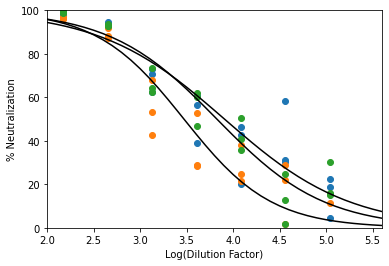

In [6]:
## Run function to calculate IC50
IC50(logs,joined)
